# Détection et représentation de fissures
Sylvia Feld-Payet

### Préambule :
si vous n’avez pas la librairie scikit-learn dans votre distribution Python, exécutez dans un terminal :
 > pip install scikit-learn --user

ou via conda :
 > conda install -c conda-forge scikit-learn

## Objectif et données
Le principal objectif de ce TP sur la détection et la représentation de fissures est
de comprendre les grandes étapes de la détermination d’un chemin de fissure discret
à partir d’un résultat de calcul pour un modèle à endommagement diffus. Pour cela,
partons du calcul par éléments finis de l’éprouvette utilisée dans l’article de S. Feld-Payet, J. Besson and F. Feyel, Finite element analysis of damage in ductile structures using a nonlocal model combined with a three-field formulation (International Journal of Damage Mechanics, 2011) et étudions le champ d’endommagement régularisé : voir figure 1.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import scipy
from scipy import signal


import mealor_td9 as td9

In [2]:
selected_time = 0.67

X_position, Y_position, damage = td9.load_data(
        datafile='calcul.post',
        selected_time = selected_time)

  - There are data for time (80 datasets) =  [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.671, 0.67258113883, 0.67508113883, 0.67861667274, 0.68256951981, 0.68691765159, 0.69177901071, 0.69224252312, 0.69297540058, 0.69401184583, 0.69547760075, 0.69736988223, 0.69948551723]
  - Data loaded for time =  0.67


## Visualization

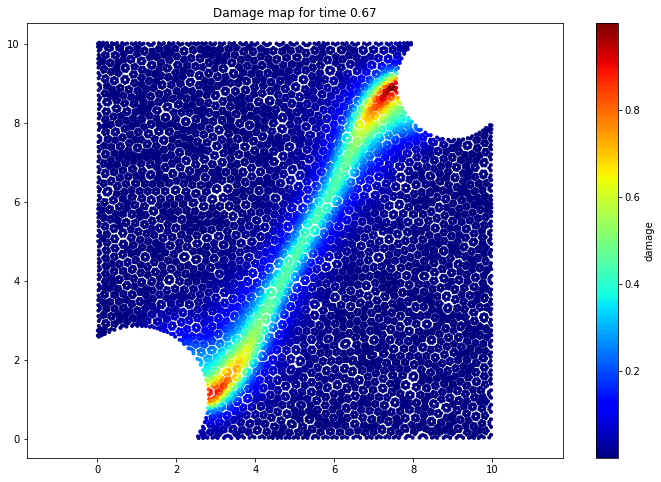

In [3]:
plt.figure(figsize=(12, 8))
plt.scatter(X_position, Y_position, c=damage, cmap='jet', marker = ".")
plt.axis("equal")
plt.colorbar(orientation="vertical", label="damage")
plt.title(f'Damage map for time {selected_time}')
plt.show()  

## Select only the higly damaged areas

In [4]:
#Damage value to distinguish higly damaged ares
threshold_damage = 0.6 #value between 0 and 1
index = np.where(np.array(damage) > threshold_damage)

high_damage_X = X_position[index]
high_damage_Y = Y_position[index]
high_damage = damage[index]

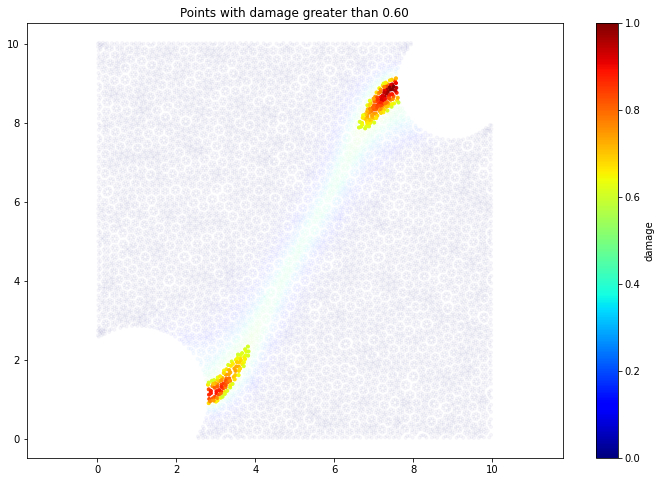

In [5]:
plt.figure(figsize=(12, 8))

plt.scatter(X_position, Y_position, c=damage, cmap='jet', marker = ".", alpha=0.03)
plt.scatter(high_damage_X, high_damage_Y, c=high_damage, cmap='jet', marker = ".")
plt.clim([0, 1])
plt.axis("equal")
plt.colorbar(orientation="vertical", label="damage")
plt.title(f"Points with damage greater than {threshold_damage:.2f}")
plt.show()

## Use DBSCAN to separate the damaged areas

In [6]:
# DBSCAN parameters
# The maximum distance between two samples for one to be considered as in the
# neighborhood of the other. This is not a maximum bound on the distances of
# points within a cluster. This is the most important DBSCAN parameter to
# choose appropriately for your data set and distance function. default=5
EPS_DBSCAN = 5
# The number of samples (or total weight) in a neighborhood for a point to be
# considered as a core point. This includes the point itself.
MIN_SAMPLES_DBSCAN = 10
# Concatenation to fit the FORMAT required by DBSCAN
data_set = np.dstack((high_damage_X, high_damage_Y))
X = data_set[0]
if len(X)>0:
    # use DBSCAN (sklearn.cluster.DBSCAN) to find clusters
    db = DBSCAN(eps=EPS_DBSCAN, min_samples=MIN_SAMPLES_DBSCAN).fit(X)
    # Count number of clouds and points in cloud and corresponding to noise
    # label -1 corresponds to noise
    labels = db.labels_
    print("labels", labels)
    labels_set = set(labels)
    print("Les labels :", labels_set)
    nb_labels = len(labels_set)
    print("Nb de labels : ", nb_labels)

labels [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
Les labels : {0, 1}
Nb de labels :  2


## Consider each damaged area independently

In [7]:
local_X = [high_damage_X[np.where(labels==label)] for label in labels_set]
local_Y = [high_damage_Y[np.where(labels==label)] for label in labels_set]
local_damage = [high_damage[np.where(labels==label)] for label in labels_set]

## Find the point with maximum damage

In [8]:
index_max = [np.argmax(local_damage[label]) for label in labels_set]
X_max_damage = [local_X[label][index_max[label]] for label in labels_set]
Y_max_damage = [local_Y[label][index_max[label]]for label in labels_set]

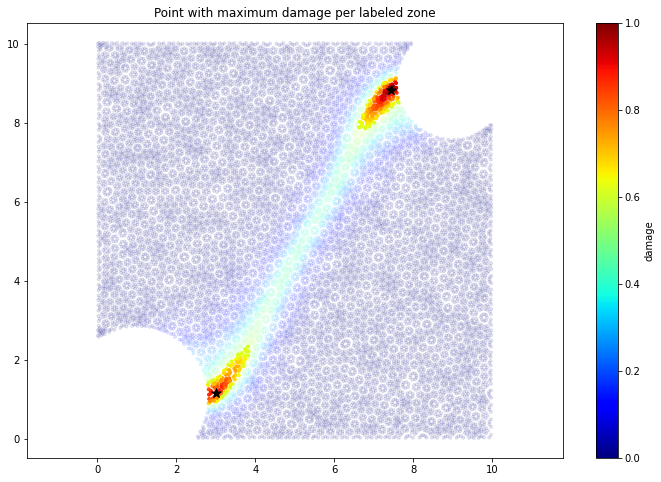

In [9]:
plt.figure(figsize=(12, 8))

plt.scatter(X_position, Y_position, c=damage, vmin=0, vmax=1,
            cmap='jet', marker = ".", alpha=0.1)
plt.scatter(high_damage_X, high_damage_Y, c=high_damage, vmin=0, vmax=1,
            cmap='jet', marker = ".")

plt.colorbar(orientation="vertical", label="damage")

plt.scatter(X_max_damage, Y_max_damage, color = "black", marker="*", s=100)
        
plt.axis("equal")
plt.title(f"Point with maximum damage per labeled zone")
plt.show()

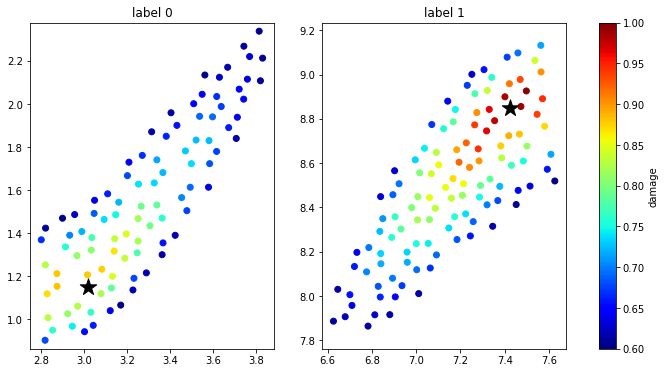

In [10]:
fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    im = ax[label].scatter(local_X[label], local_Y[label], c=local_damage[label], cmap='jet', marker = "o")
    im.set_clim(threshold_damage, 1)
    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")

plt.colorbar(im, ax=ax, label="damage")
plt.show()

## Position evaluation points on a circle

In [11]:
radius = 0.15
angular_accuracy = 5 # degrees
eval_angles = np.deg2rad(np.arange(0,360,angular_accuracy))

X_evaluation_point_position = [_X+radius*np.cos(eval_angles) for _X in X_max_damage]
Y_evaluation_point_position = [_Y+radius*np.sin(eval_angles) for _Y in Y_max_damage]


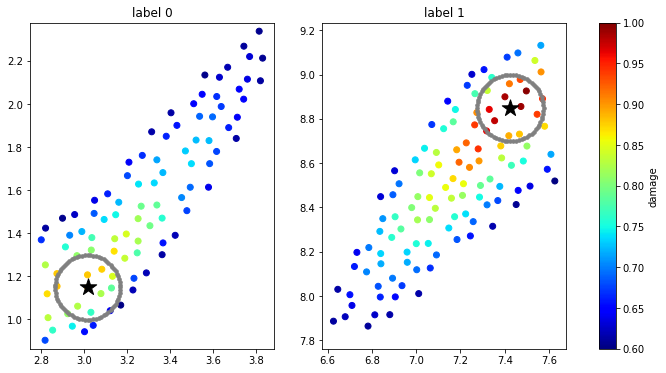

In [12]:
fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    ax[label].scatter(local_X[label], local_Y[label], 
                      c=local_damage[label], vmin=threshold_damage, vmax=1,
                      cmap='jet', marker = "o")
    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    ax[label].scatter(X_evaluation_point_position[label], 
                      Y_evaluation_point_position[label],
                      color = 'gray', marker='.', s=50, label='evaluation point')
                    
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")
plt.colorbar(im, ax=ax, label="damage")
plt.show()

## Evaluate damage on the circle

In [13]:
sample_size = 13


#Find the closest points to the evaluation point for polynomial approximation
approx_damage= []

def get_estimated_local_damage(_x, _y, label):
    _X_sample,_Y_sample, _damage_sample = td9.find_closest_points(
        _x, _y,                                           # point we want
        local_X[label], local_Y[label], # labelled points
        sample_size, local_damage[label])
    estimated_damage = td9.second_order_polynomial_approximation(
        _x, _y, _X_sample, _Y_sample, _damage_sample)
    return estimated_damage

for label in labels_set:
    approx_damage.append(
        np.array([
            get_estimated_local_damage(_x, _y, label) 
                for _x, _y in zip(X_evaluation_point_position[label], Y_evaluation_point_position[label])
        ])
    )
# approx_damage

/home/clebourlot/Documents/docs-MATEIS/01_Projet/MEALORII/TP/TP_MEALOR/TP9_Detection_fissures/mealor_td9.py:89: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol, res, rank , s = np.linalg.lstsq(A, B)


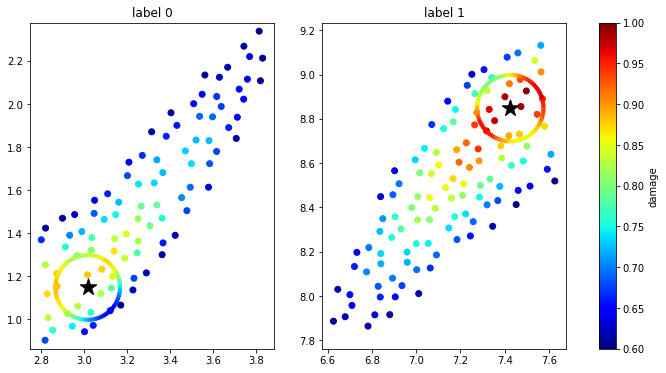

In [14]:
fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    im = ax[label].scatter(local_X[label], local_Y[label], c=local_damage[label], 
                           cmap='jet', marker = "o", vmin=threshold_damage, vmax=1)

    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    ax[label].scatter(X_evaluation_point_position[label], 
                      Y_evaluation_point_position[label],
                      c=approx_damage[label], cmap='jet', vmin=threshold_damage, vmax=1,
                      marker='.', s=50, label='evaluation point')
                    
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")
plt.colorbar(im, ax=ax, label="damage")
plt.show()

## Damage evolution analysis to find relative max values

In [15]:
wrapped_evaluation_angles = np.array([-eval_angles[1], *eval_angles])
wrapped_approx_damage = [
    np.array([approx_damage[label][-1], *approx_damage[label]])
    for label in labels_set]

Label 0
    max indices: [12 36 38]
    max  angles: [ 55. 175. 185.]
Label 1
    max indices: [ 6 10 25 43 45]
    max  angles: [ 25.  45. 120. 210. 220.]


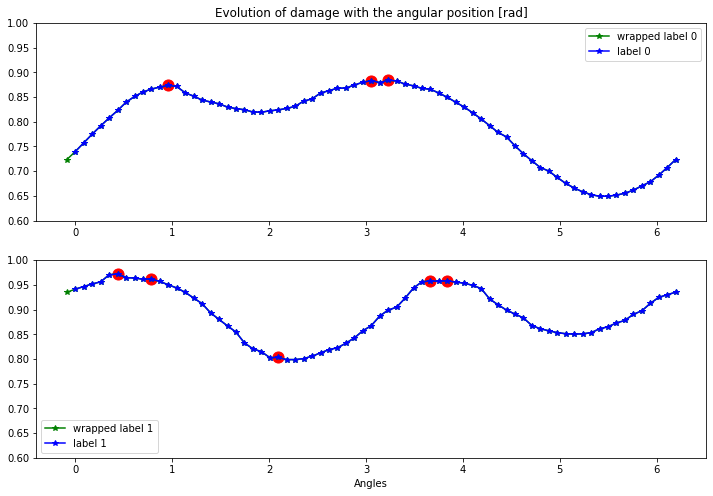

In [16]:

max_indices = [ scipy.signal.argrelmax(wrapped_approx_damage[label])[0] 
               for label in labels_set]
#max_indices = np.array(max_indices)
for label in labels_set:
    print(f"Label {label}")
    print("    max indices:", max_indices[label])
    print("    max  angles:", np.rad2deg(wrapped_evaluation_angles[max_indices[label]]))


fig, ax = plt.subplots(nb_labels, 1, figsize=(12, 8))

for label in labels_set:
    ax[label].plot(wrapped_evaluation_angles, wrapped_approx_damage[label],
                   "*-", color = "g", label=f"wrapped label {label}")
    ax[label].plot(eval_angles, approx_damage[label], 
                   "*-", color="b", label=f"label {label}")
    ax[label].scatter(wrapped_evaluation_angles[max_indices[label]], 
                      wrapped_approx_damage[label][max_indices[label]], 
                      color='r', s=123)
    ax[label].legend()
    ax[label].set_ylim([threshold_damage, 1])

ax[0].set_title("Evolution of damage with the angular position [rad]")
ax[-1].set_xlabel("Angles")
plt.show()

## Damage evolution analysis on smoothed curved to find relative max values

After smoothing, damage is max for angles: 
Label 0
    max indices: [12 37]
    max  angles: [ 55. 180.]
Label 1
    max indices: [ 6 44]
    max  angles: [ 25. 215.]


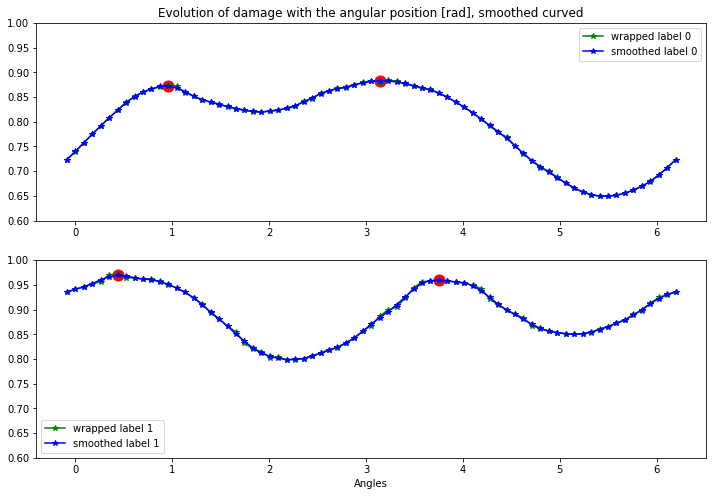

In [17]:
#Need to be less dependent on the data discretization
#More radii or smoothing
window_length = 7
polyorder = 2

smoothed_curve = [scipy.signal.savgol_filter(approx_damage[label], window_length, polyorder, mode="wrap")
                  for label in labels_set]
wrapped_smoothed_curve = [
    np.array([smoothed_curve[label][-1], *smoothed_curve[label]])
    for label in labels_set]

max_indices = [ scipy.signal.argrelmax(wrapped_smoothed_curve[label])[0] for label in labels_set]
print("After smoothing, damage is max for angles: ")
for label in labels_set:
    print(f"Label {label}")
    print("    max indices:", max_indices[label])
    print("    max  angles:", np.rad2deg(wrapped_evaluation_angles[max_indices[label]]))

    
fig, ax = plt.subplots(nb_labels, 1, figsize=(12, 8))

for label in labels_set:
    ax[label].plot(wrapped_evaluation_angles, wrapped_approx_damage[label],
                   "*-", color = "g", label=f"wrapped label {label}")
    ax[label].plot(wrapped_evaluation_angles, wrapped_smoothed_curve[label], 
                   "*-", color="b", label=f"smoothed label {label}")
    ax[label].scatter(wrapped_evaluation_angles[max_indices[label]], 
                      wrapped_smoothed_curve[label][max_indices[label]], 
                      color='r', s=123)
    ax[label].legend()
    ax[label].set_ylim([threshold_damage, 1])

ax[0].set_title("Evolution of damage with the angular position [rad], smoothed curved")
ax[-1].set_xlabel("Angles")
plt.show()

## Plot segments

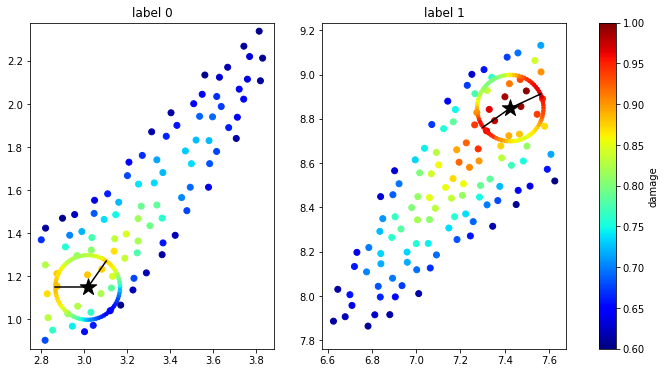

In [18]:
fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    im = ax[label].scatter(local_X[label], local_Y[label], 
                           c=local_damage[label], vmin=threshold_damage, vmax=1,
                           cmap='jet', marker = "o")
    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    ax[label].scatter(X_evaluation_point_position[label], 
                      Y_evaluation_point_position[label],
                      c=approx_damage[label], vmin=threshold_damage, vmax=1,
                      cmap='jet', marker='.', s=50, label='evaluation point')
         
    for num_branch in np.arange(0,len(max_indices[label])):
        _angle = wrapped_evaluation_angles[max_indices[label][num_branch]] 
        X_ridge_point = X_max_damage[label] + radius*np.cos(_angle )
        Y_ridge_point = Y_max_damage[label] + radius*np.sin(_angle )
        ax[label].plot([X_max_damage[label], X_ridge_point],
                       [Y_max_damage[label], Y_ridge_point], c="black")            
        
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")
plt.colorbar(im, ax=ax, label="damage")
plt.show()
  

## Evaluate damage along the maximum damage direction

In [19]:
delta_L = 0.2 * radius
nbpts = 20
segment_X = []
segment_Y = []
segment_D = []

for label in labels_set:
    print(f"Label {label}")
    _segment_Xl = []
    _segment_Yl = []
    _segment_Dl = []
    for index_angle in max_indices[label]: 
        _angle = wrapped_evaluation_angles[index_angle]
        print("   Damage is max for angle ", np.rad2deg(_angle) )
        X_on_segment = X_max_damage[label] + np.arange(0,nbpts) * delta_L*np.cos(_angle)
        Y_on_segment = Y_max_damage[label] + np.arange(0,nbpts) * delta_L*np.sin(_angle)
        damage_on_segment = np.array([
            get_estimated_local_damage(_x, _y, label) 
                for _x, _y in zip(X_on_segment, Y_on_segment)
        ])
        _segment_Xl.append(X_on_segment)
        _segment_Yl.append(Y_on_segment)
        _segment_Dl.append(damage_on_segment)
    segment_X.append(_segment_Xl)
    segment_Y.append(_segment_Yl)
    segment_D.append(_segment_Dl)

Label 0
   Damage is max for angle  55.0
   Damage is max for angle  180.0
Label 1
   Damage is max for angle  25.0
   Damage is max for angle  215.0


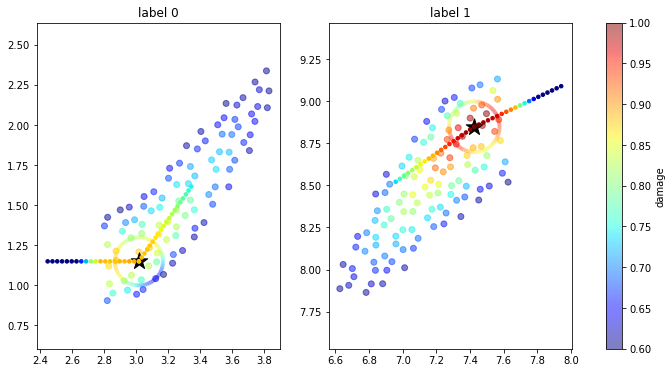

In [20]:
fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    im = ax[label].scatter(local_X[label], local_Y[label], 
                           c=local_damage[label], vmin=threshold_damage, vmax=1,
                           cmap='jet', marker = "o", alpha=0.5)
    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    ax[label].scatter(X_evaluation_point_position[label], 
                      Y_evaluation_point_position[label],
                      c=approx_damage[label], vmin=threshold_damage, vmax=1,
                      cmap='jet', marker='.', s=50, alpha=0.2,  label='evaluation point')
    for m,_ in enumerate(max_indices[label]):
        ax[label].scatter(segment_X[label][m], 
                          segment_Y[label][m],
                          c=segment_D[label][m], vmin=threshold_damage, vmax=1,
                          cmap='jet', marker='.', s=50, label='evaluation point')
                
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")
plt.colorbar(im, ax=ax, label="damage")
plt.show()
  

## Evaluate crack increment length

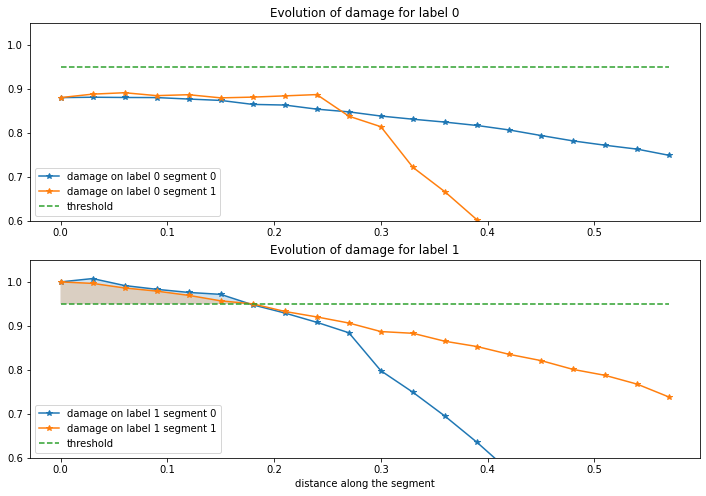

In [29]:
#Select only the points with damage greater than limit_damage
limit_damage =  0.95


fig, ax = plt.subplots(nb_labels, 1, figsize=(12, 8))

_X = np.arange(0, nbpts)*delta_L

for label in labels_set:
    for m in range(len(max_indices[label])):
        ax[label].plot(_X, segment_D[label][m], 
                       "-*",
                       label=f"damage on label {label} segment {m}")
        ax[label].fill_between(_X, segment_D[label][m], 
                               limit_damage,
                               where=segment_D[label][m]>limit_damage,
                               interpolate=True, alpha=0.2)
    ax[label].plot(_X, limit_damage*np.ones_like(_X), 
                   '--',
                   label='threshold')
        
    ax[label].legend()
    ax[label].set_ylim(threshold_damage, 1.05)

    ax[label].set_title(f"Evolution of damage for label {label}")
ax[-1].set_xlabel("distance along the segment")
plt.show()

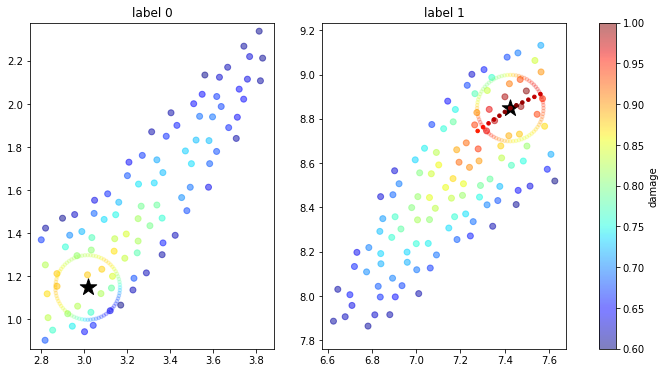

In [24]:
X_all_segments = []
Y_all_segments = []

fig, ax = plt.subplots(1,nb_labels, figsize=(12, 6))

for label in labels_set:
    im = ax[label].scatter(local_X[label], local_Y[label], 
                           c=local_damage[label], vmin=threshold_damage, vmax=1,
                           cmap='jet', marker = "o", alpha=0.5)
    ax[label].scatter(X_max_damage[label], Y_max_damage[label], color = "black", marker="*", s=300)
    ax[label].scatter(X_evaluation_point_position[label], 
                      Y_evaluation_point_position[label],
                      c=approx_damage[label], vmin=threshold_damage, vmax=1,
                      cmap='jet', marker='.', s=50, alpha=0.2,  label='evaluation point')

    for m in range(len(max_indices[label])):
        _mask_damage = np.where(segment_D[label][m]>limit_damage)
        if len(_mask_damage[0]):
            X_all_segments.append([X_max_damage[label], segment_X[label][m][_mask_damage][-1]])
            Y_all_segments.append([Y_max_damage[label], segment_Y[label][m][_mask_damage][-1]])
            ax[label].scatter(segment_X[label][m][_mask_damage], 
                              segment_Y[label][m][_mask_damage],
                              c=segment_D[label][m][_mask_damage], vmin=threshold_damage, vmax=1,
                              cmap='jet', marker='.', s=50, label='evaluation point')
                
    ax[label].axis("equal")
    ax[label].set_title(f"label {label}")
plt.colorbar(im, ax=ax, label="damage")
plt.show()
  

## Visualize final result

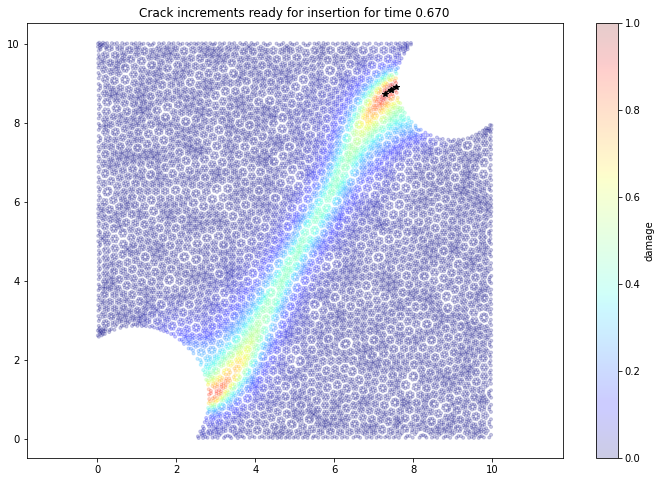

In [23]:
plt.figure(figsize=(12, 8))

plt.scatter(X_position, Y_position, c=damage, cmap='jet', marker = ".", alpha=0.2)
#plt.scatter(high_damage_X, high_damage_Y, c=high_damage, 
#            cmap='jet', marker = ".", alpha=0.3)

plt.clim([0, 1])
plt.colorbar(orientation="vertical", label="damage")

for index in np.arange(0, len(X_all_segments)):
    plt.plot(X_all_segments[index], Y_all_segments[index], "-*", c="black")
        
plt.axis("equal")
plt.title(f"Crack increments ready for insertion for time {selected_time:.3f}")
plt.show()